In [3]:
import pandas as pd

walking = pd.read_csv('data/walking.csv')
falling_part1 = pd.read_csv('data/falling1.csv')
falling_part2 = pd.read_csv('data/falling2.csv')
falling_part3 = pd.read_csv('data/falling3.csv')
kneeling = pd.read_csv('data/kneeling.csv')

def adjust_df(df, label):
    df = df.iloc[6:].reset_index(drop=True)
    df.drop(columns=['time', 'TgF'], inplace=True)
    df['label'] = label
    return df

walking = adjust_df(walking, 'walking')
falling_part1 = adjust_df(falling_part1, 'falling')
falling_part2 = adjust_df(falling_part2, 'falling')
falling_part3 = adjust_df(falling_part3, 'falling')
kneeling = adjust_df(kneeling, 'kneeling')


# all all dataframes together
df = pd.concat([walking, falling_part1, falling_part2, falling_part3, kneeling], ignore_index=True)
df['gFx_diff'] = df['gFx'].diff()
df['gFy_diff'] = df['gFy'].diff()
df['gFz_diff'] = df['gFz'].diff()
df.dropna(inplace=True)

#* save to csv
df.to_csv('data/cleaned_up_part1.csv', index=False)



In [10]:
huge_data = pd.read_csv('data/data_part4.csv')
huge_data['label'] = 'unkown'
huge_data['label'][5000:11000] = 'kneeling'
huge_data['label'][11000:16600] = 'walking'
huge_data['label'][16600:22500] = 'falling'
huge_data = huge_data[huge_data['label'] != 'unkown'].reset_index(drop=True)
huge_data.drop(columns=['time', 'TgF'], inplace=True)
huge_data['gFx_diff'] = huge_data['gFx'].diff()
huge_data['gFy_diff'] = huge_data['gFy'].diff()
huge_data['gFz_diff'] = huge_data['gFz'].diff()
huge_data.dropna(inplace=True)
huge_data.to_csv('data/cleaned_up_part2.csv', index=False)
huge_data



C:\Users\DELL\AppData\Local\Temp\ipykernel_10844\2026509141.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  huge_data['label'][5000:11000] = 'kneeling'
C:\Users\DELL\AppData\Local\Temp\ipykernel_10844\2026509141.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  huge_data['label'][11000:16600] = 'walking'
C:\Users\DELL\AppData\Local\Temp\ipykernel_10844\2026509141.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  huge_data['labe

,gFx,gFy,gFz,label,gFx_diff,gFy_diff,gFz_diff
1,-0.1966,0.6958,-0.4094,kneeling,0.002,-0.002,0.000
2,-0.1966,0.6958,-0.4094,kneeling,0.000,0.000,0.000
3,-0.1966,0.6958,-0.4094,kneeling,0.000,0.000,0.000
4,-0.1986,0.6958,-0.4094,kneeling,-0.002,0.000,0.000
5,-0.1986,0.6938,-0.4094,kneeling,0.000,-0.002,0.000
...,...,...,...,...,...,...,...
17495,0.1478,0.6137,-0.5935,falling,0.002,-0.002,-0.002
17496,0.1478,0.6117,-0.5935,falling,0.000,-0.002,0.000
17497,0.1478,0.6097,-0.5935,falling,0.000,-0.002,0.000
17498,0.1478,0.6077,-0.5975,falling,0.000,-0.002,-0.004


<Axes: >

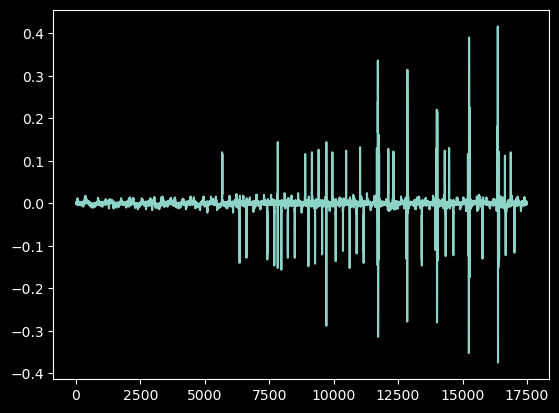

In [11]:
huge_data['gFx_diff'].plot()

<Axes: >

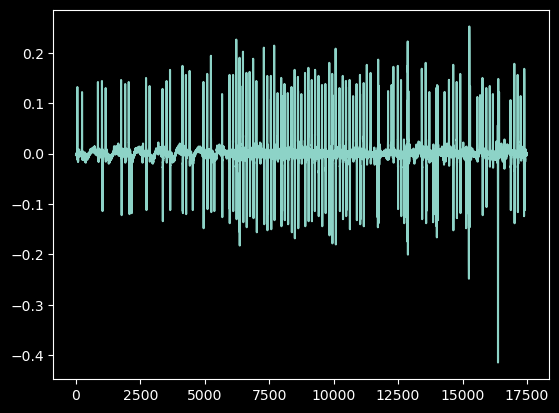

In [12]:
huge_data['gFy_diff'].plot()

<Axes: >

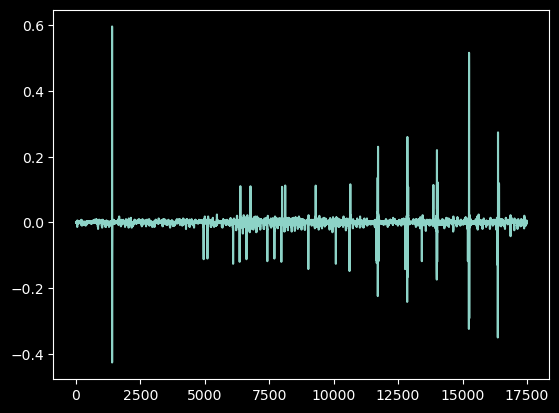

In [13]:
huge_data['gFz_diff'].plot()

In [ ]:
from scipy import stats
import numpy as np
from sklearn.preprocessing import label_binarize


def create_windowed_dataset(data, target, window=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(data) - window, step):
        v = data.iloc[i : (i + window)].values
        labels = target.iloc[i : i + window]
        Xs.append(v)
        # ys.append(stats.mode(labels)[0][0])
        ys.append(labels.mode()[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)


data = df.drop(columns=["label"])
target = df["label"]
X_train, y_train = create_windowed_dataset(data, target, window=10, step=1)
y_train = label_binarize(y_train, classes=['walking', 'falling', 'kneeling'])

In [ ]:
# import tensorflow as tf
from tensorflow import keras

model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.build(input_shape=(None, 10, 3))
model.summary()

In [ ]:
# tf callbacks
SavingBestmodel = keras.callbacks.ModelCheckpoint(
    "best_model.h5", monitor="acc", mode="max", verbose=1, save_best_only=True
)



In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=8,
    shuffle=False,
    callbacks=[SavingBestmodel]
)